In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import get_topic_clusters, create_embeddings, load_or_create_measurements_df, load_and_process_movielens, collect_parameters, load_measurements
from src.scoring_functions import cosine_sim, entropy, content_fairness
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, RecallMeasurement

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

## Creating RecommenderSystem on MovieLens 

In [2]:
n_attrs=20
max_iter=1000
n_clusters=20

In [3]:
binary_ratings_matrix = load_and_process_movielens(file_path='data/ml-100k/u.data')

In [4]:
# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

Loaded embeddings.


In [5]:
# Define topic clusters using NMF
item_topics = get_topic_clusters(binary_ratings_matrix, n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

Loaded clusters.


In [6]:
# Create user clusters based off how often they interacted with the same item
print('Calculating clusters...')
co_occurence_matrix = binary_ratings_matrix @ binary_ratings_matrix.T
print(co_occurence_matrix.shape)

# Matrix factorize co_occurence_matrix to get embeddings
nmf_cooc = NMF(n_components=n_attrs, max_iter=max_iter)
W_topics = nmf_cooc.fit_transform(co_occurence_matrix)

# cluster W_topics
cluster_ids = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=random_state).fit_predict(W_topics)

print('Calculated clusters.')

Calculating clusters...
(943, 943)


/opt/conda/envs/rsenv2/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  ConvergenceWarning,


Calculated clusters.


# Simulation

### Model

In [7]:
score_fn = ''
probabilistic = False
globals.ALPHA = 0.2
alpha = globals.ALPHA

# User parameters
drift = 0.2
attention_exp=1.5
pair_all=False

In [8]:
num_users = len(user_representation)
num_items = len(item_representation)
print(f'Number of items: {num_items}')
print(f'Number of users: {num_users}')

if pair_all:
    # All possible user pairs
    user_pairs = [(u_idx, v_idx) for u_idx in range(len(user_representation)) for v_idx in range(len(user_representation))]

else:
    # create user_pairs by pairing users only with others that are not in the same cluster
    user_pairs = []
    for u_idx in range(num_users):
        for v_idx in range(num_users):
            if cluster_ids[u_idx] != cluster_ids[v_idx]:
                user_pairs.append((u_idx, v_idx))
print(f'Number of user pairs: {len(user_pairs)}')
                
users = Users(actual_user_profiles=user_representation, 
              repeat_interactions=False, 
              drift=drift,
              attention_exp=attention_exp)

Number of items: 20
Number of users: 943
Number of user pairs: 790474


In [9]:
mse = MSEMeasurement()
measurements_list = [
    InteractionMeasurement(), 
    mse,  
    InteractionSpread(), 
    InteractionSimilarity(pairs=user_pairs), 
    RecSimilarity(pairs=user_pairs), 
    SerendipityMetric(), 
    DiversityMetric(), 
    NoveltyMetric(),
    RecallMeasurement(),
    # MeanNumberOfTopics(),
]

In [10]:
# Model
config = {
    'actual_user_representation': users,
    'actual_item_representation': item_representation,
    'item_topics': item_topics,
    'num_attributes': n_attrs,
    'num_items_per_iter': 10,
    'seed': 42,
    'record_base_state': True,
}

model_name='myopic'
requires_alpha = False

if score_fn:
    if score_fn == 'cosine_sim':
        config['score_fn'] = cosine_sim
        requires_alpha = True
    elif score_fn == 'entropy':
        config['score_fn'] = entropy
        requires_alpha = True
    elif score_fn == 'content_fairness':
        config['score_fn'] = content_fairness        
    else:
        raise Exception('Given score function does not exist.')
    model_name = score_fn

if probabilistic:
    config['probabilistic_recommendations'] = True
    model_name += '_prob'

In [11]:
model = BubbleBurster(**config)

model.add_metrics(*measurements_list)

print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {model.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {model.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 20)
- A randomly generated matrix of items of dimension (20, 1682)


In [12]:
# Fair Model
train_timesteps=10
model.startup_and_train(timesteps=train_timesteps)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.92s/it]


In [13]:
run_timesteps=20
model.run(timesteps=run_timesteps)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [04:15<00:00, 12.78s/it]


Measurements saved.


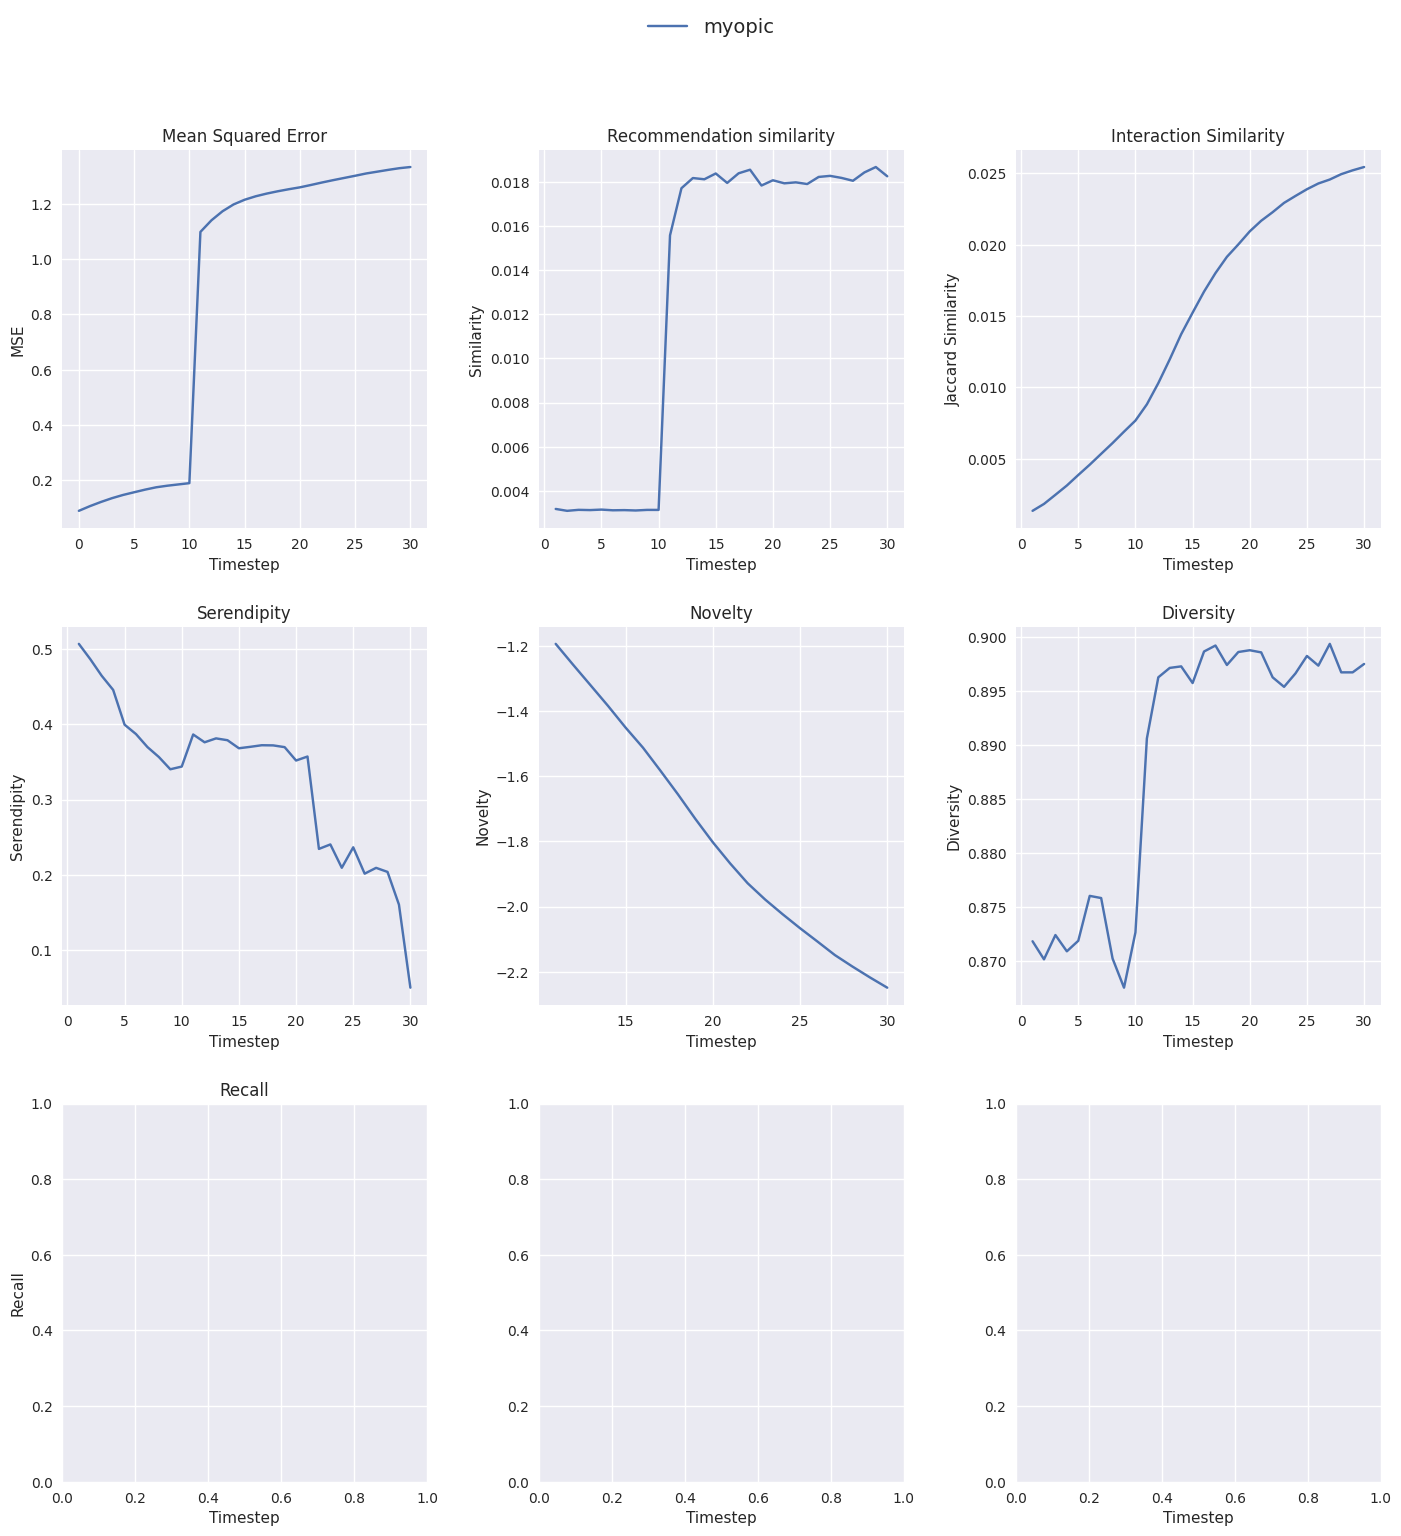

In [14]:
import src
reload(src.utils)
from src.utils import *
    
# Save measurements
measurements_dir = f'artefacts/measurements/'
file_name = f'{model_name}_measurements_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp_{pair_all}PairAll'
measurements_path = measurements_dir + file_name
if requires_alpha:
    measurements_path += f'_{alpha}Lambda'
measurements_path += '.csv'
measurements_df = load_or_create_measurements_df(model, model_name, train_timesteps, measurements_path)
measurements_df.to_csv(measurements_path)
print('Measurements saved.')

# Create df for parametrics
numeric_cols = ['trainTimesteps', 'runTimesteps', 'nAttrs', 'nClusters', 'Lambda']
columns = ['model_name'] + numeric_cols

data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, None]]
if requires_alpha:
    data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, alpha]]

parameters_df = pd.DataFrame(data,
                             columns = columns)
for col in numeric_cols:
    parameters_df[col] = pd.to_numeric(parameters_df[col])
    
plot_measurements([measurements_df], parameters_df)

# Experiments

In [21]:
recommender = model

item_counts = recommender.item_count
item_counts[item_counts == 0] = 1
items_self_info = (-1) * np.log(item_counts)

# turn scores in probability distribution over items to ensure that all independent of the ranking function, the metric yields comparable values
scores = recommender.predicted_scores.value
probs = scores / np.sum(scores, axis=1)[:, np.newaxis]

# get utility of each item given a state of users
item_states = np.mean(probs, axis=0)

# calculate novelty per item by multiplying self information and utility value
item_novelties = items_self_info * item_states
# form sum over all possible items/actions
item_novelty = np.sum(item_novelties)

In [22]:
item_novelty

-2.249291926581003

In [149]:
k = 5

shown_item_scores = np.take(recommender.predicted_scores.value, recommender.items_shown)
shown_item_ranks = np.argsort(shown_item_scores, axis=1)
top_k_items = np.empty((len(shown_item_ranks), k), dtype=int)
for i, u in enumerate(recommender.items_shown):
    top_k_items[i] = np.take(u, shown_item_ranks[i, k:])
recall = (
    len(np.where(np.isin(recommender.interactions, top_k_items))[0]) / recommender.num_users
)


recall

0.7879109225874867

In [134]:
recommender.items_shown[1]

array([1362,   53,   23,  409, 1497, 1024,  482,  132,  193,  749])

In [135]:
shown_item_scores[1]

array([1.46461148, 1.12042488, 1.12042488, 1.60750778, 1.63040357,
       2.62401506, 1.91274607, 1.11429418, 1.57215739, 0.75080972])

In [136]:
shown_item_ranks[1]

array([9, 7, 1, 2, 0, 8, 3, 4, 6, 5])

In [147]:
top_k_items[1]

array([ 193,  409, 1497,  482, 1024])

In [131]:
coords = [[u, i] for u in range(len(shown_item_ranks)) for i in shown_item_ranks[u, k:]]
Y = [c[0] for c in coords]
X = [c[1] for c in coords]
recommender.items_shown[Y, X].reshape(len(recommender.items_shown), k)[1]

array([ 193,  409, 1497,  482, 1024])

In [122]:
shown_item_scores = np.take(recommender.predicted_scores.value[1], recommender.items_shown[1])
shown_item_ranks = np.argsort(shown_item_scores)
top_k_items = np.take(recommender.items_shown[1], shown_item_ranks[k:])
print('Goal: ', top_k_items)

Goal:  [1024  482  132  193  749]


In [124]:
recommender.items_shown[1, 3]

409

In [65]:
print(shown_item_scores.shape)
print(shown_item_ranks.shape)
print(top_k_items.shape)

(943, 10)
(943, 10)
(943, 5)


In [105]:
coords

[[0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9],
 [1, 8],
 [1, 3],
 [1, 4],
 [1, 6],
 [1, 5],
 [2, 3],
 [2, 4],
 [2, 6],
 [2, 1],
 [2, 0],
 [3, 7],
 [3, 5],
 [3, 2],
 [3, 3],
 [3, 9],
 [4, 0],
 [4, 2],
 [4, 3],
 [4, 4],
 [4, 8],
 [5, 3],
 [5, 4],
 [5, 2],
 [5, 0],
 [5, 9],
 [6, 9],
 [6, 2],
 [6, 1],
 [6, 5],
 [6, 8],
 [7, 7],
 [7, 8],
 [7, 0],
 [7, 4],
 [7, 6],
 [8, 1],
 [8, 2],
 [8, 6],
 [8, 5],
 [8, 7],
 [9, 0],
 [9, 5],
 [9, 3],
 [9, 6],
 [9, 8],
 [10, 8],
 [10, 9],
 [10, 1],
 [10, 7],
 [10, 0],
 [11, 9],
 [11, 1],
 [11, 2],
 [11, 4],
 [11, 6],
 [12, 6],
 [12, 4],
 [12, 9],
 [12, 0],
 [12, 3],
 [13, 3],
 [13, 7],
 [13, 2],
 [13, 1],
 [13, 8],
 [14, 9],
 [14, 4],
 [14, 8],
 [14, 2],
 [14, 6],
 [15, 1],
 [15, 5],
 [15, 2],
 [15, 8],
 [15, 7],
 [16, 2],
 [16, 6],
 [16, 0],
 [16, 1],
 [16, 5],
 [17, 7],
 [17, 5],
 [17, 0],
 [17, 4],
 [17, 8],
 [18, 8],
 [18, 3],
 [18, 0],
 [18, 5],
 [18, 7],
 [19, 8],
 [19, 0],
 [19, 7],
 [19, 9],
 [19, 6],
 [20, 6],
 [20, 0],
 [20, 9],
 [20, 8],
 [20, 1],
